##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 2,57
MultiplierThresholdToBlock <strong>L 50</strong>, FractionThresholdToUnBlock 1, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.49;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]
filesInfected = [
    {"filename": "Netsim-Node-Metrics-IsInfected-{log_tag}", "title": "Доля инфицированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
summInfected = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatInfected():
    for file in filesInfected:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля инфицированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summInfected.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            dataI, line_lenI = load_csv_file(f"{log_dir_path}/{filesInfected[0]['filename'].format(log_tag = log_tag['tag'])}")
                                           
            aggregated, count = aggeregate_line_perc_node(data)
            aggregatedI, count = aggeregate_line_perc_node(dataI)
            aggregated = np.array(aggregated) - np.array(aggregatedI)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    showStatInfected();

def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

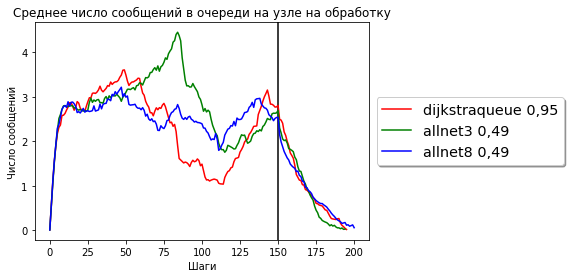

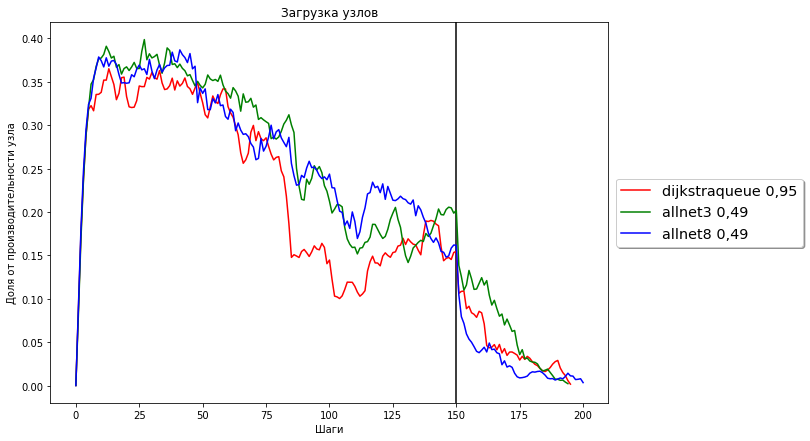

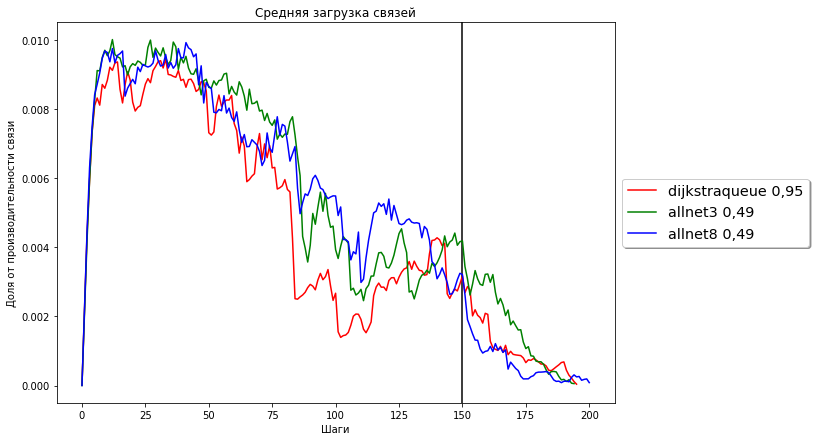

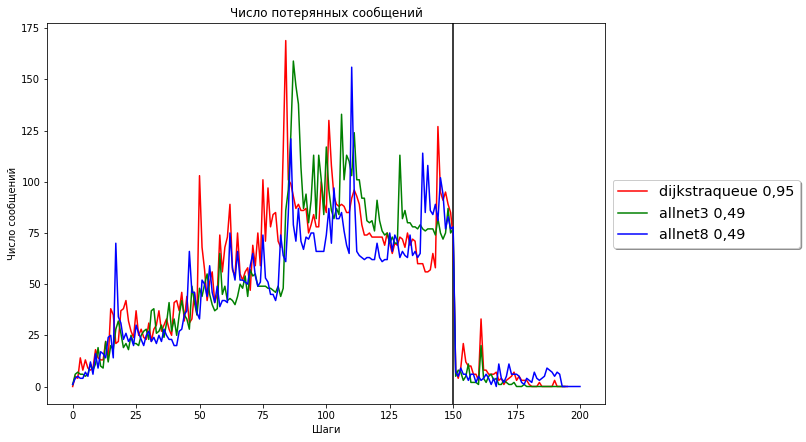

Доставлено 5682 Потеряно 62.1225% -dijkstraqueue 0,95
Доставлено 6061 Потеряно 59.5960% -allnet3 0,49
Доставлено 6772 Потеряно 54.8563% -allnet8 0,49


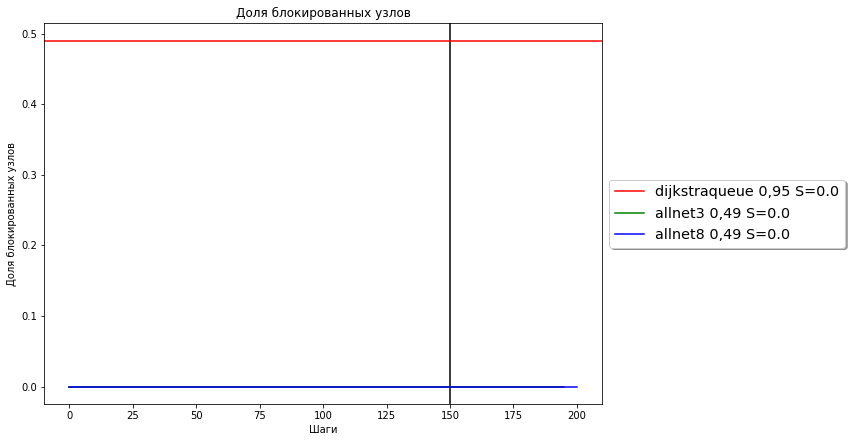

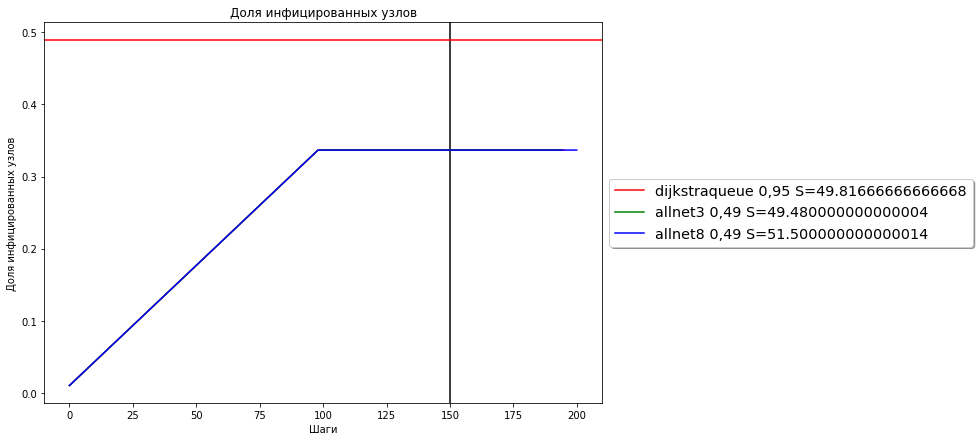

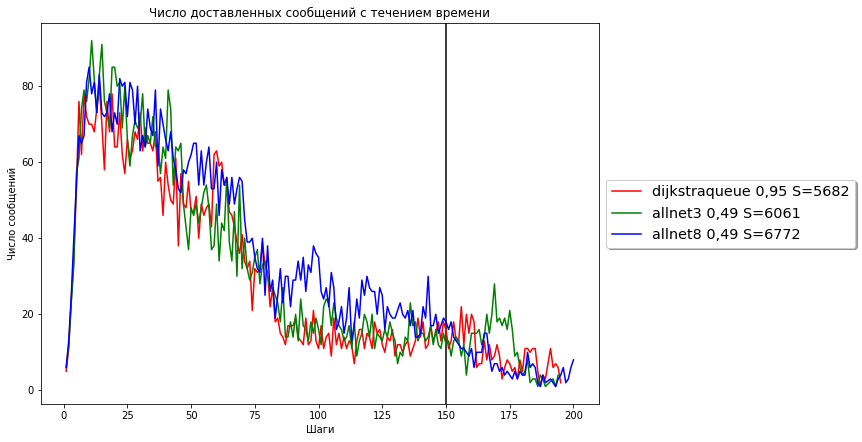

In [2]:
quantity = 100;
log_tags = [
{"tag":  "17fbf40d-421f-4d78-a273-e2bae8792cb1", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "62cb1637-d068-492d-b759-01e4f6907d7c", "label": "allnet3 0,49", "color": "green"},
{"tag":  "c0de9c92-4c9e-4041-a2b4-de2c23a4fdb2", "label": "allnet8 0,49", "color": "blue"},
]
                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

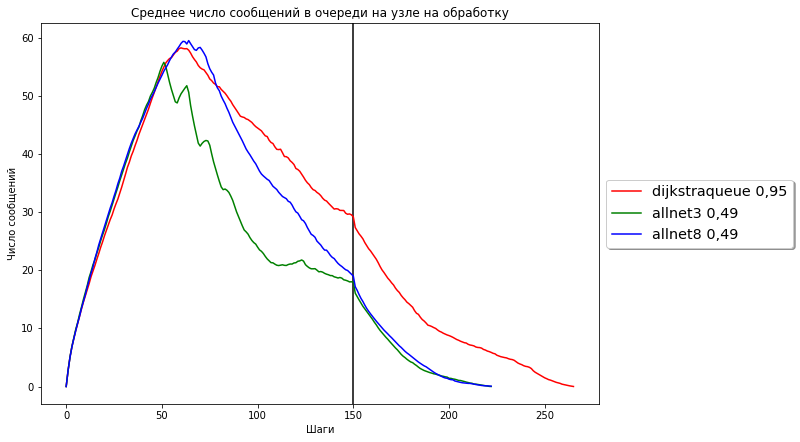

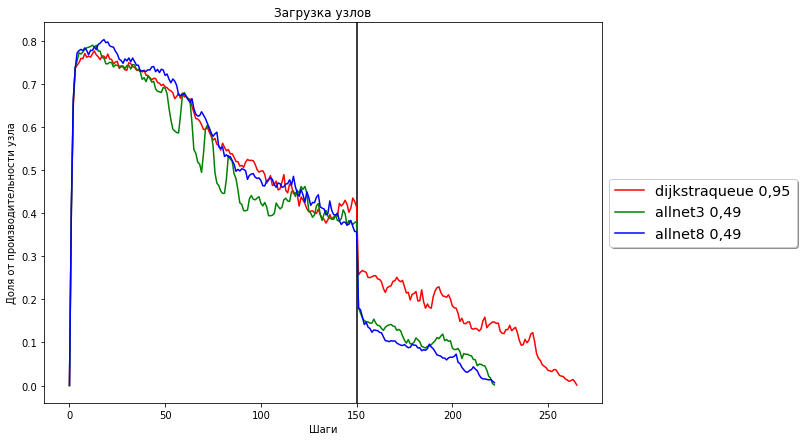

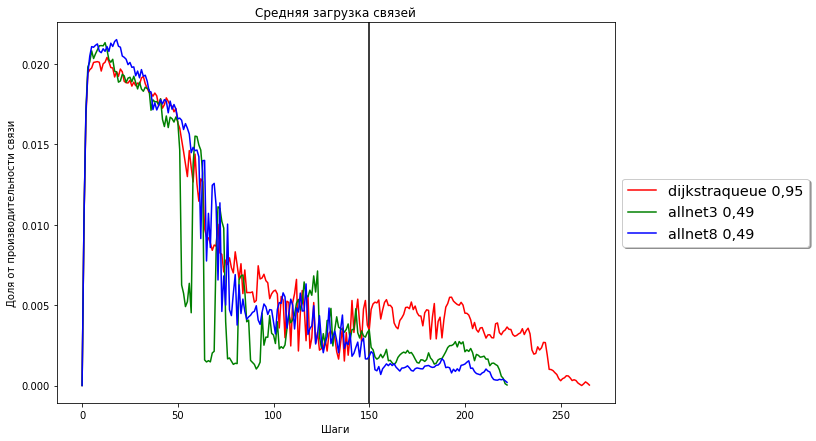

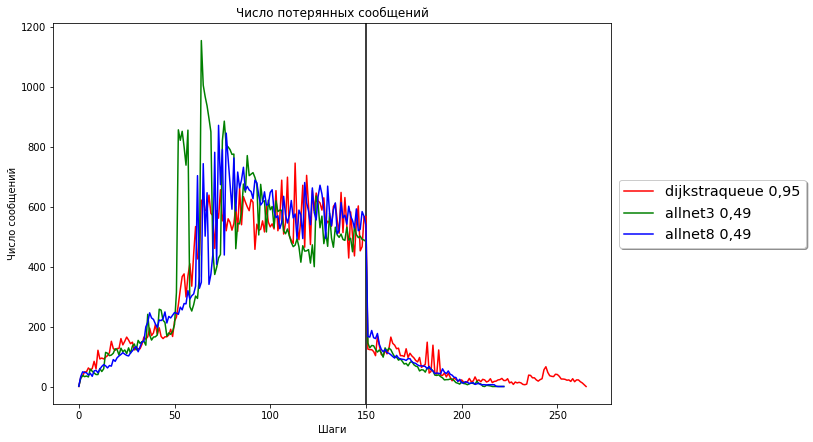

Доставлено 8365 Потеряно 88.8468% -dijkstraqueue 0,95
Доставлено 7301 Потеряно 90.2655% -allnet3 0,49
Доставлено 7842 Потеряно 89.5441% -allnet8 0,49


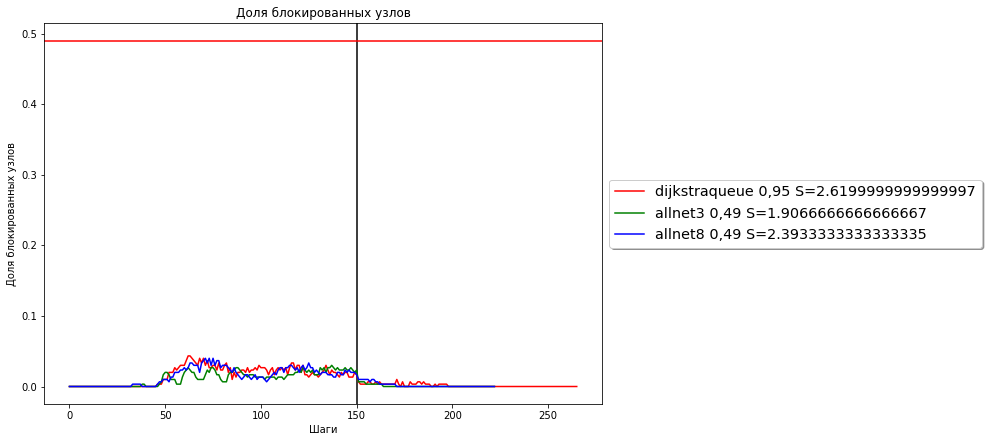

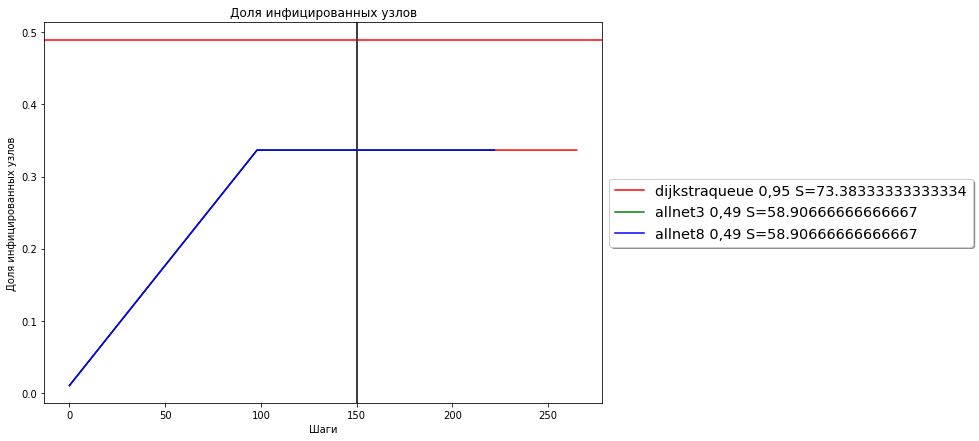

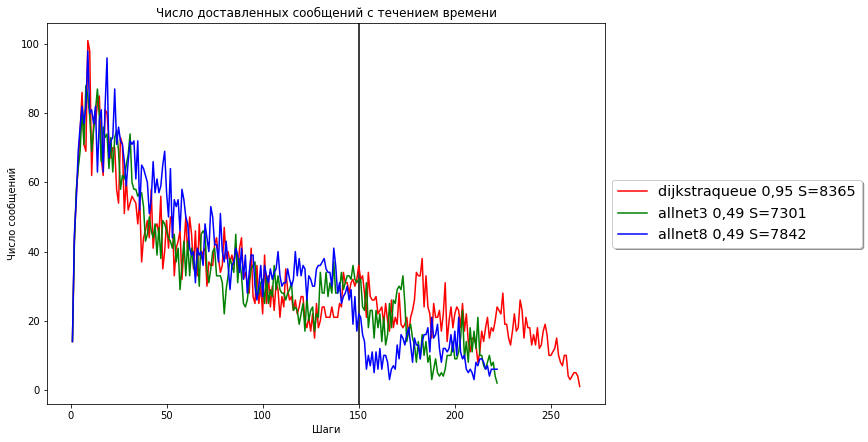

In [3]:
quantity = 500;
log_tags = [
{"tag":  "9670b75a-041a-4667-9fa2-f4deffcd8f8d", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "53d0d327-3429-43b8-8b74-f97eace7be8e", "label": "allnet3 0,49", "color": "green"},
{"tag":  "6786d547-dd73-4d77-a41c-acfd28740517", "label": "allnet8 0,49", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

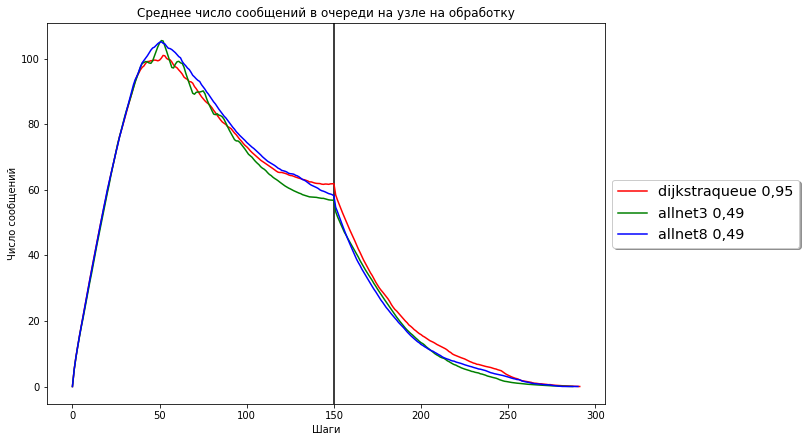

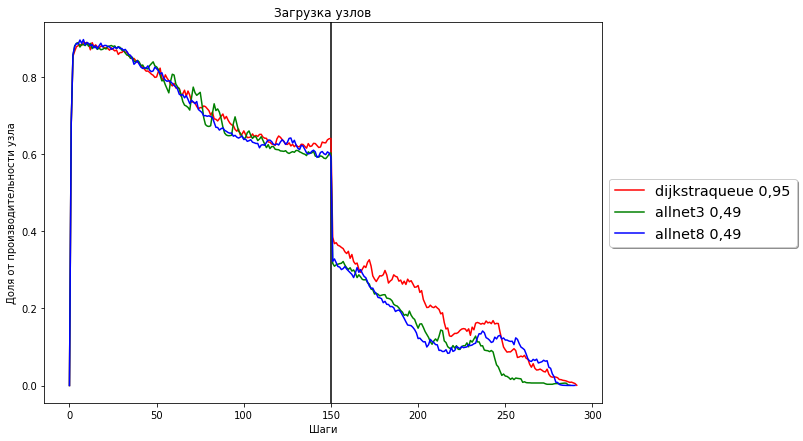

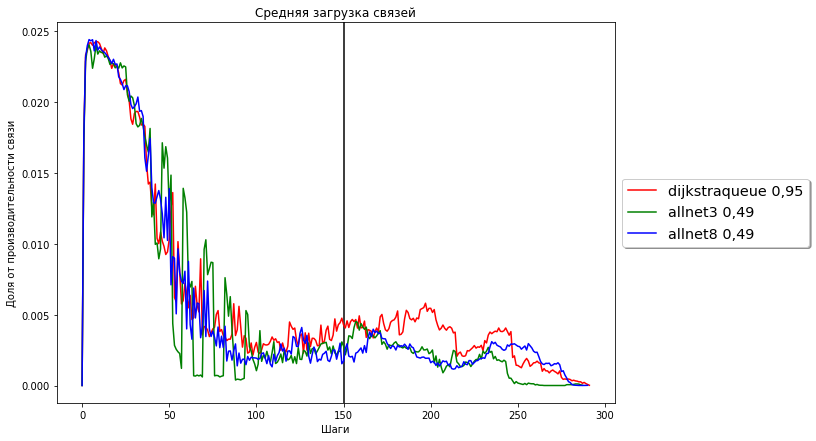

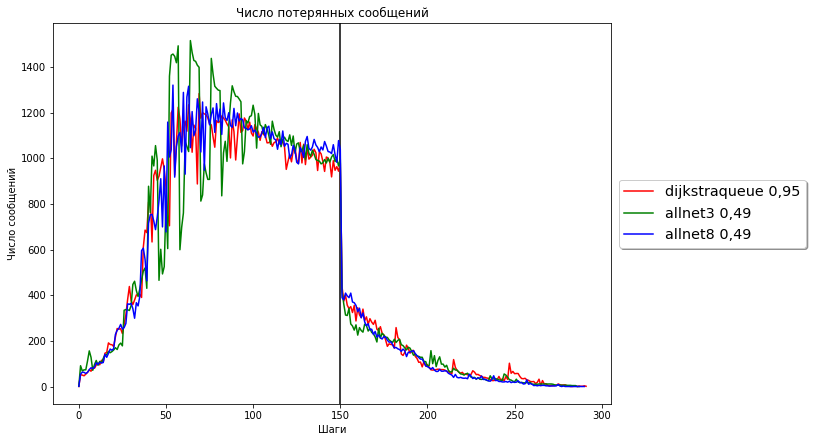

Доставлено 8579 Потеряно 94.2807% -dijkstraqueue 0,95
Доставлено 7430 Потеряно 95.0467% -allnet3 0,49
Доставлено 8552 Потеряно 94.2987% -allnet8 0,49


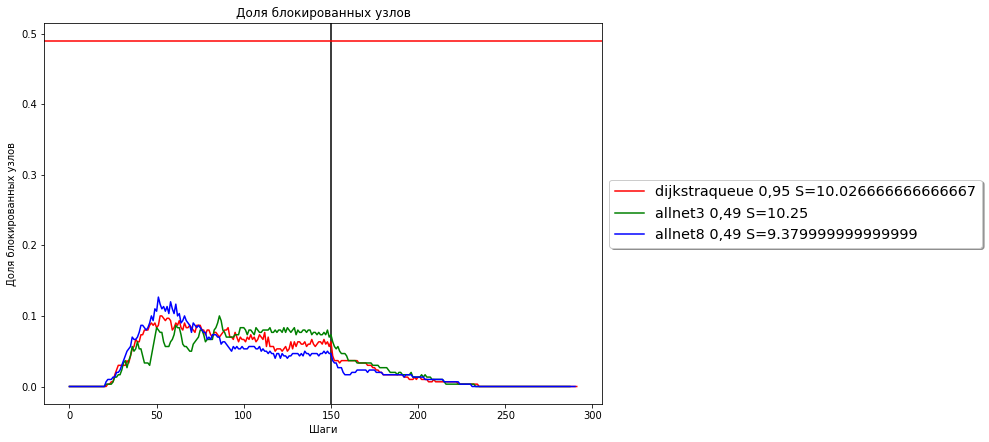

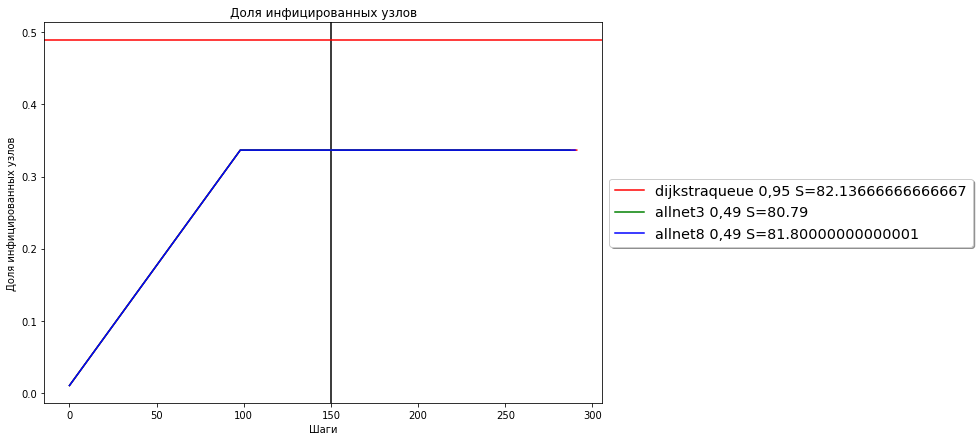

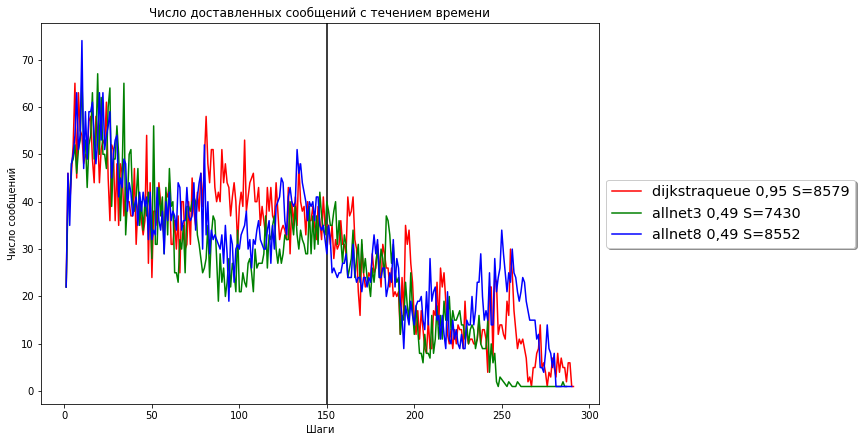

In [4]:
quantity = 1000;
log_tags = [
{"tag":  "77f278e9-2723-4a07-b86d-99d2636808af", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "70018d25-9d7f-4531-a653-c36408147b2d", "label": "allnet3 0,49", "color": "green"},
{"tag":  "1f18c659-a8ad-442d-ba4c-aa529d9b7b62", "label": "allnet8 0,49", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

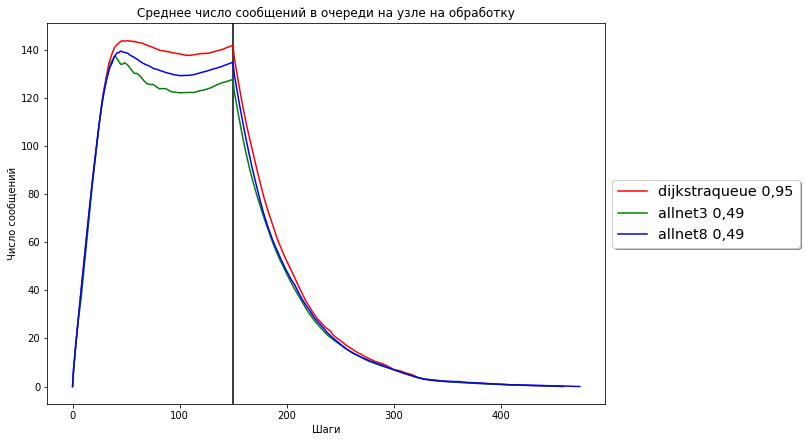

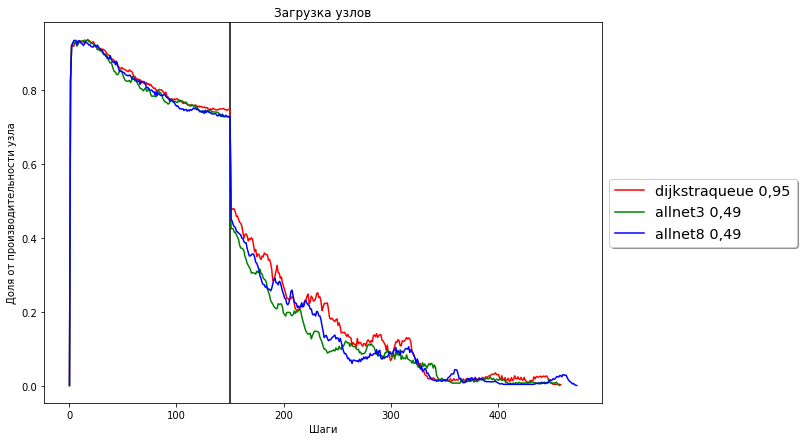

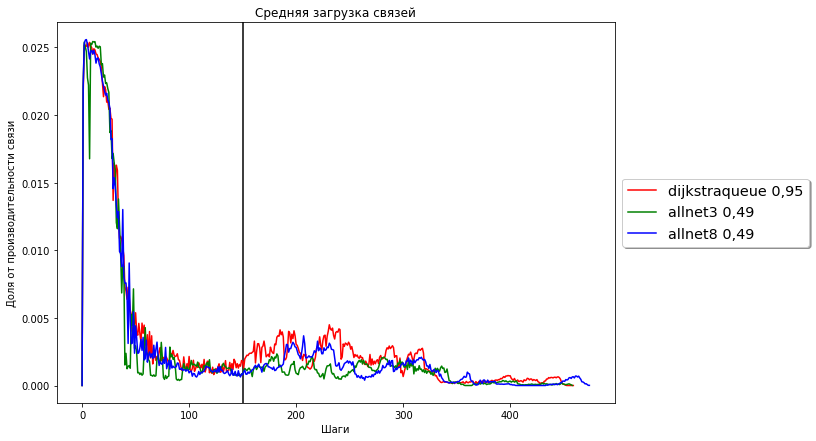

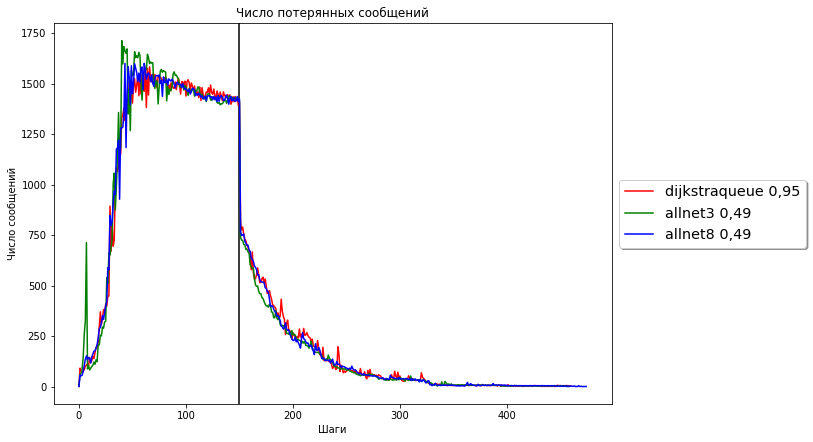

Доставлено 7893 Потеряно 96.4920% -dijkstraqueue 0,95
Доставлено 7395 Потеряно 96.7133% -allnet3 0,49
Доставлено 7585 Потеряно 96.6289% -allnet8 0,49


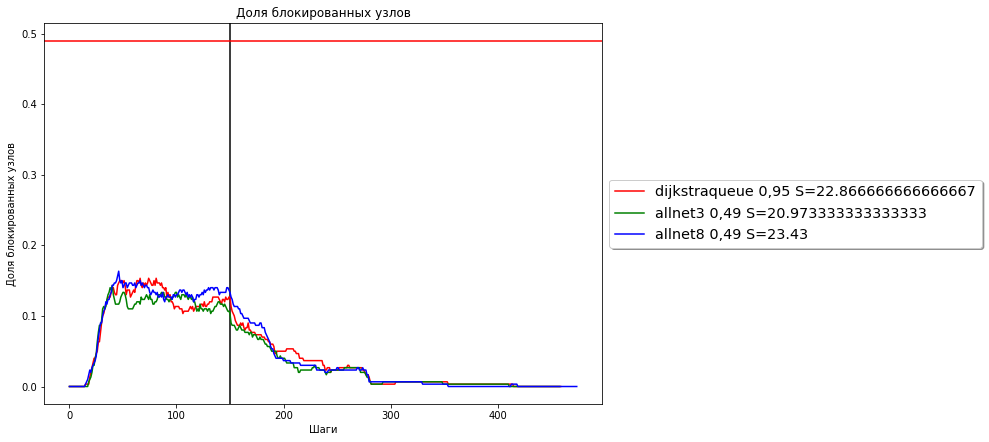

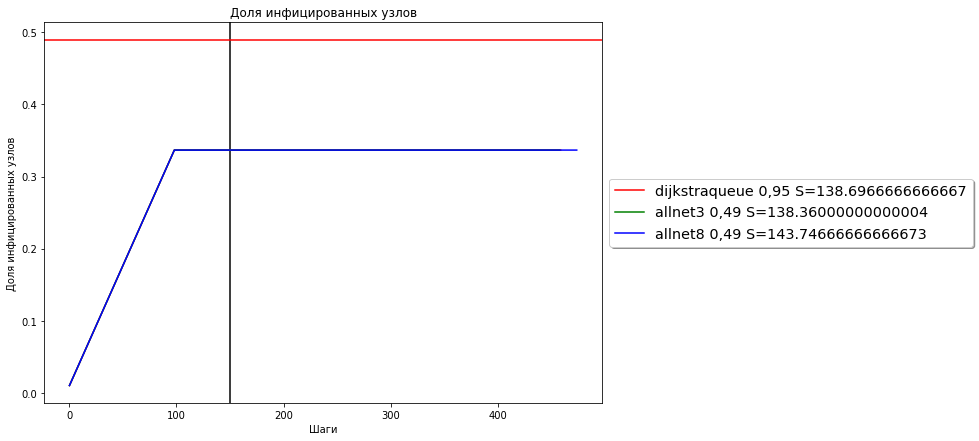

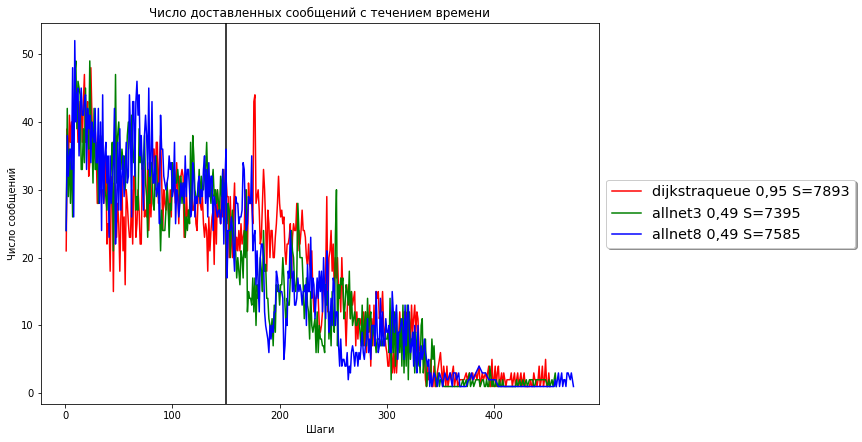

In [5]:
quantity = 1500;
log_tags = [
{"tag":  "d44209d7-4b4e-432f-b836-186b3cd3133d", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "d4cc8ac4-e9c4-4f7c-80a0-3369aab3901a", "label": "allnet3 0,49", "color": "green"},
{"tag":  "26a5ad57-5207-47f0-b15e-cf8bea43c5ee", "label": "allnet8 0,49", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 7147 Потеряно 84.1181% -dijkstraqueue 0,95
Доставлено 8889 Потеряно 80.2471% -allnet3 0,49
Доставлено 8084 Потеряно 82.0360% -allnet8 0,49


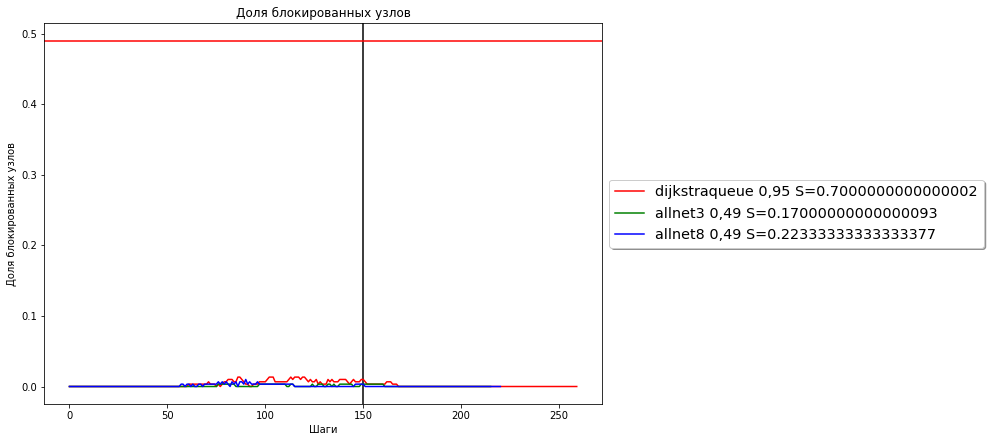

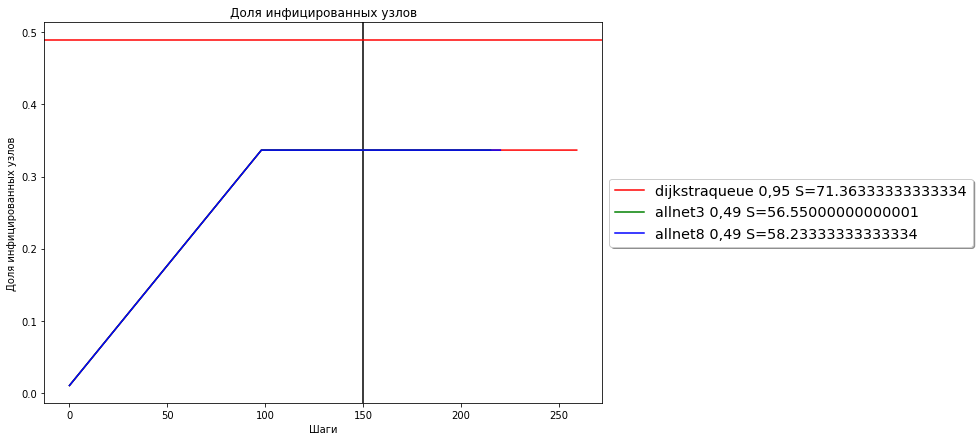

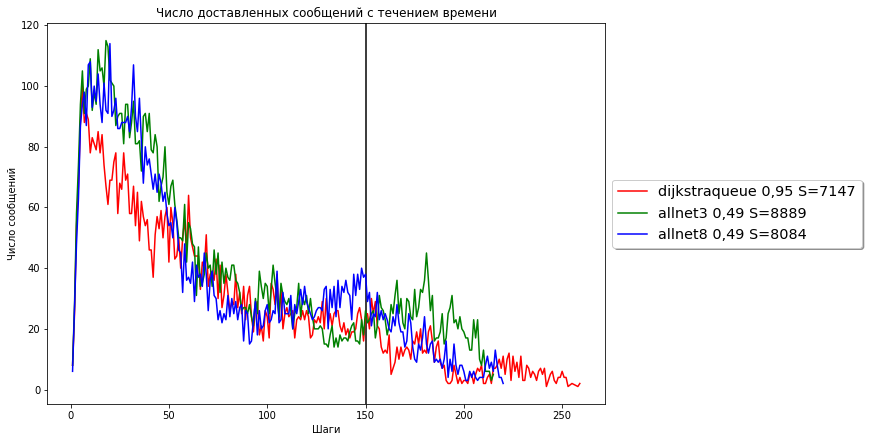

Доставлено 8124 Потеряно 92.2629% -dijkstraqueue 0,95
Доставлено 7951 Потеряно 92.4277% -allnet3 0,49
Доставлено 8651 Потеряно 91.7610% -allnet8 0,49


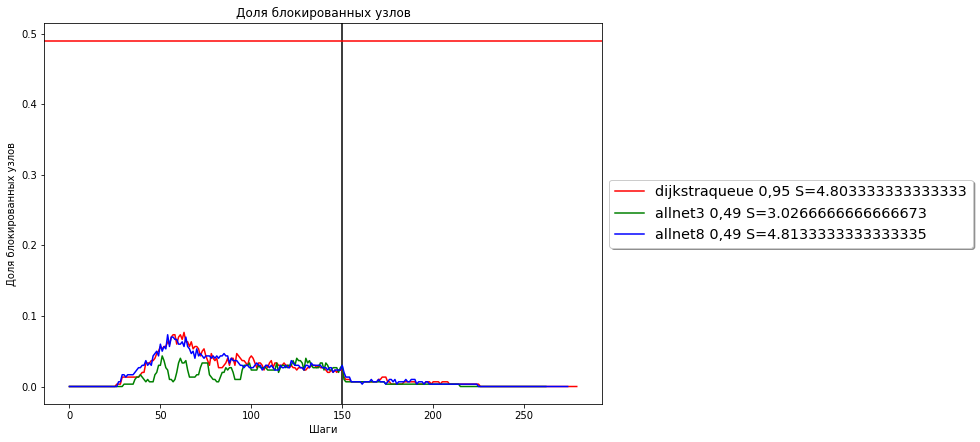

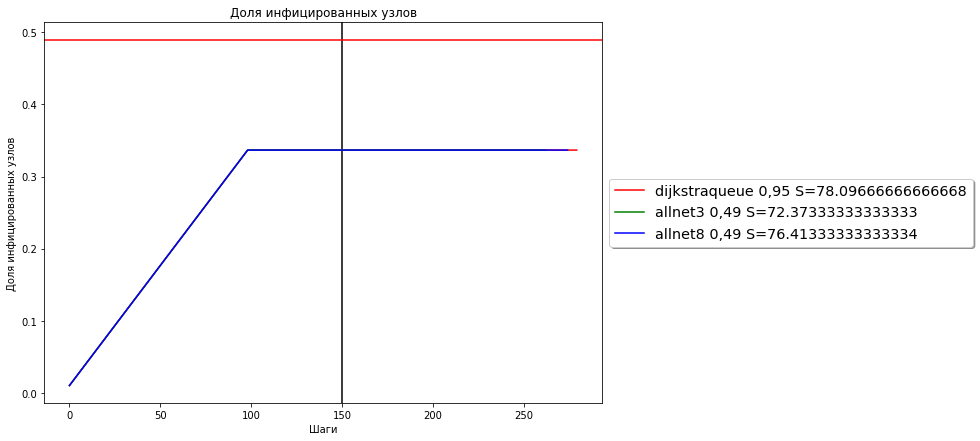

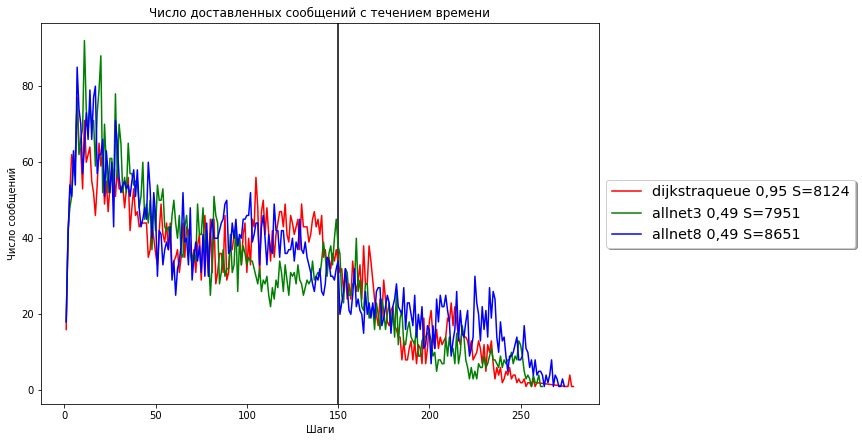

Доставлено 7884 Потеряно 94.1600% -dijkstraqueue 0,95
Доставлено 7984 Потеряно 94.0860% -allnet3 0,49
Доставлено 7678 Потеряно 94.3126% -allnet8 0,49


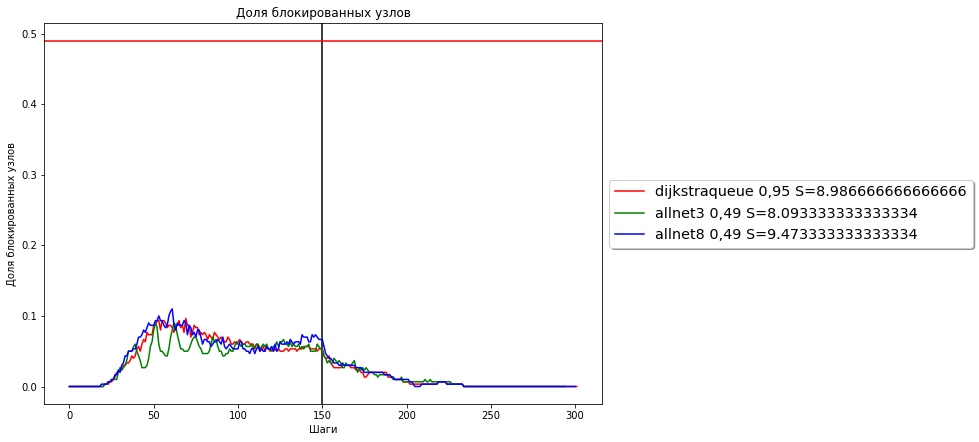

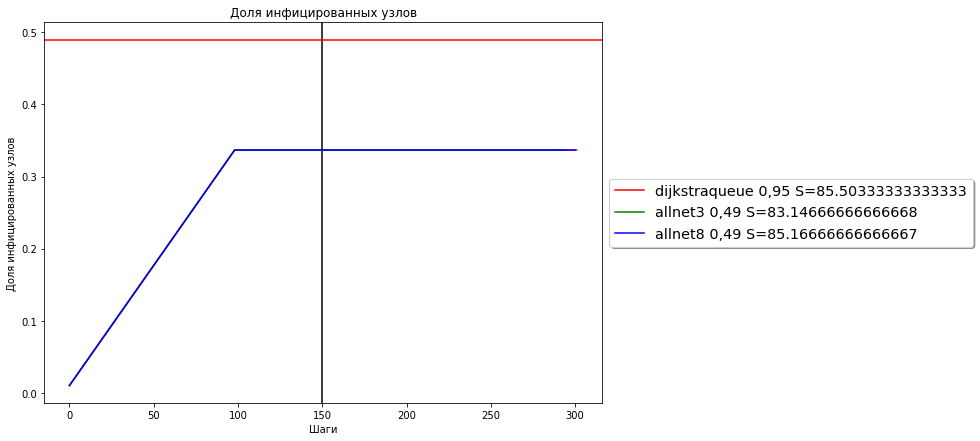

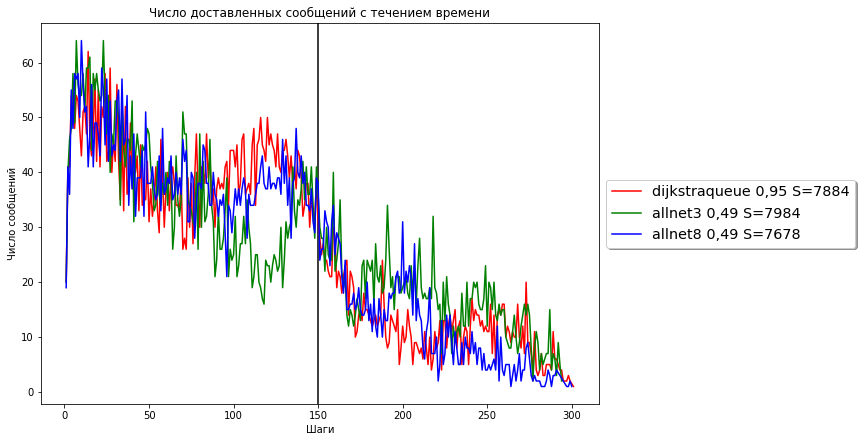

Доставлено 7780 Потеряно 96.0103% -dijkstraqueue 0,95
Доставлено 9397 Потеряно 95.1811% -allnet3 0,49
Доставлено 9434 Потеряно 95.1621% -allnet8 0,49


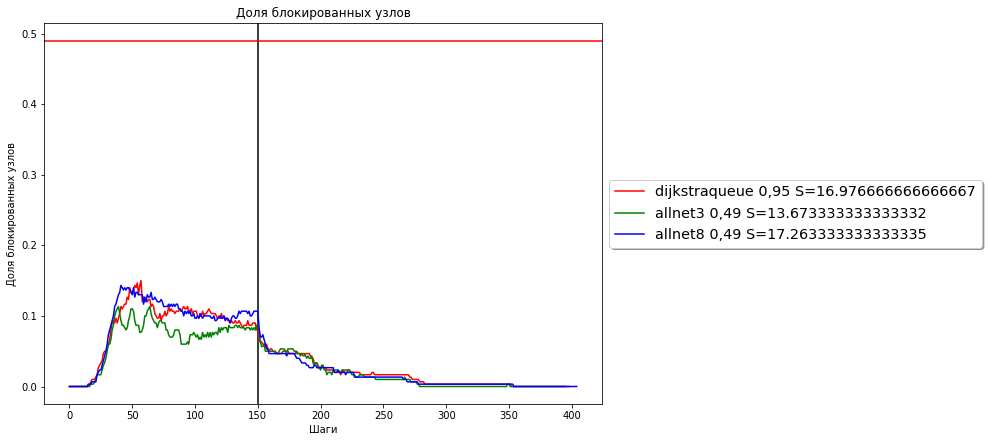

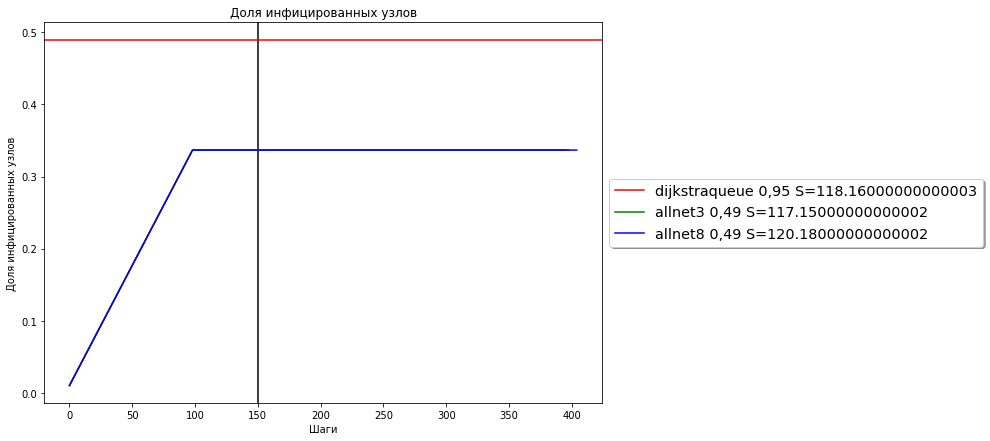

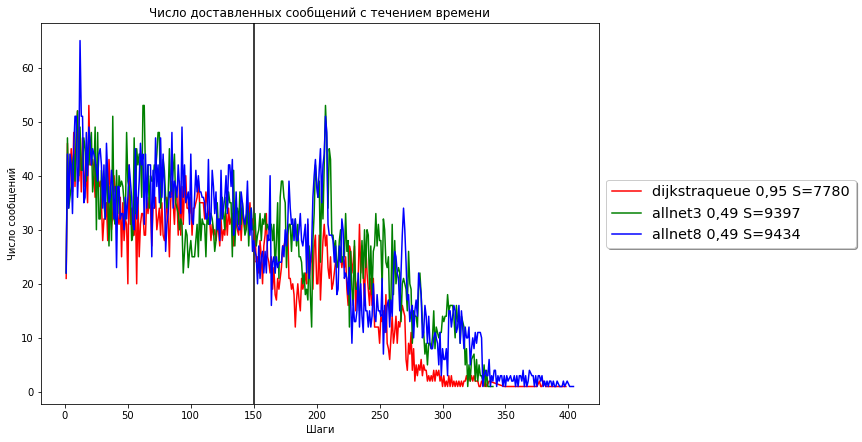

In [6]:

quantity = 300;
log_tags = [
{"tag":  "e2681425-125e-4776-8085-488b019d0c0e", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "681bde77-f2e8-4f2c-b04b-e5bcd5791364", "label": "allnet3 0,49", "color": "green"},
{"tag":  "373c48ee-b298-4379-b562-c54df3859f3b", "label": "allnet8 0,49", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 700;
log_tags = [
{"tag":  "02afdc31-a92b-454e-a965-d54f313d9b1f", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "389ccd38-49a8-4bfe-950b-87e479b213d2", "label": "allnet3 0,49", "color": "green"},
{"tag":  "9cfb21b1-2722-44f4-8852-c22fb85a6b02", "label": "allnet8 0,49", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 900;
log_tags = [
{"tag":  "dd9ef3e4-719f-43bb-beab-45d612e01dd5", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "3b8cf75e-1dcd-490f-a260-cedc96e1d964", "label": "allnet3 0,49", "color": "green"},
{"tag":  "ac596f2c-16d4-43b4-bdd7-6aa1d7428f45", "label": "allnet8 0,49", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 1300;
log_tags = [
{"tag":  "73b1fe06-14a4-498e-8c04-38fbcf9ca29a", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "7c44e088-2731-4373-90ae-89e86afeff88", "label": "allnet3 0,49", "color": "green"},
{"tag":  "88778532-47c5-4071-b493-e2fefbb2282a", "label": "allnet8 0,49", "color": "blue"},
]
showStatBlocked();
showStatMessage();

      dijkstraqueue 0,95  allnet3 0,49  allnet8 0,49
100             5.918005      6.869675      6.194587
300            21.661496     18.578409     21.398369
500            27.259277     18.995547     22.969454
700            24.552890     20.290245     25.214093
900            24.913215     24.614914     24.555618
1000           25.732415     24.893574     25.596249
1300           29.308321     28.644176     28.088841
1500           34.243319     31.156884     32.492762


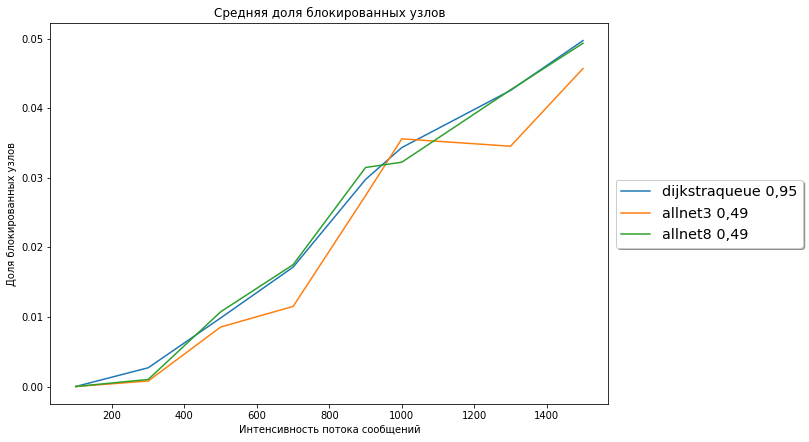

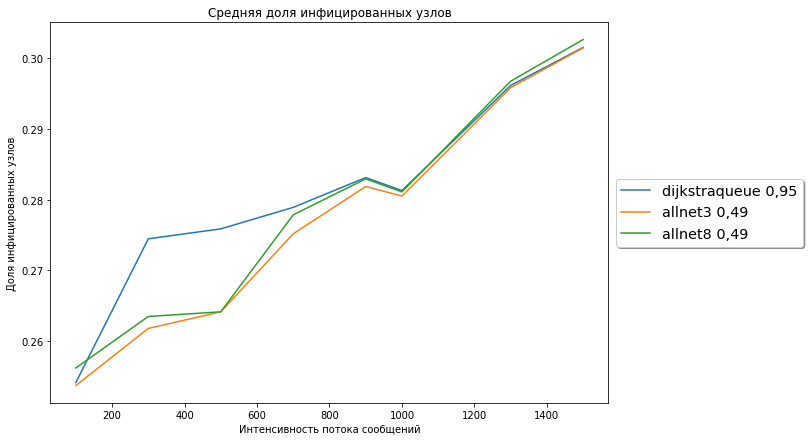

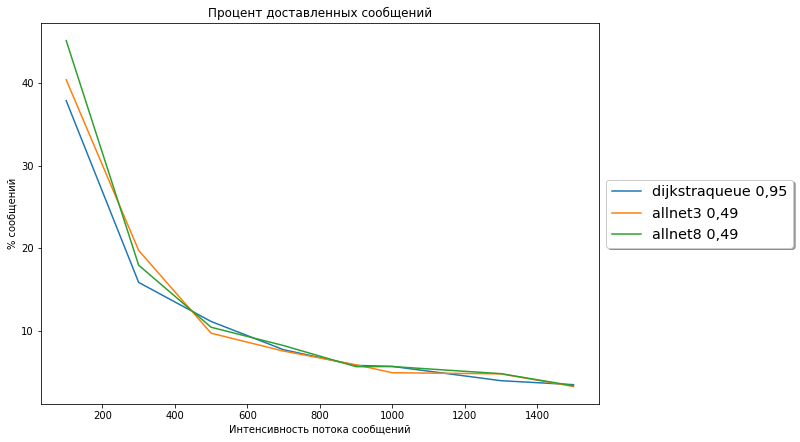

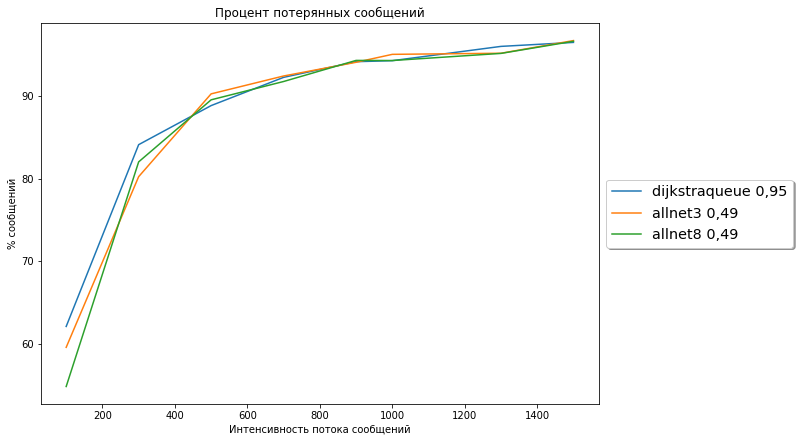

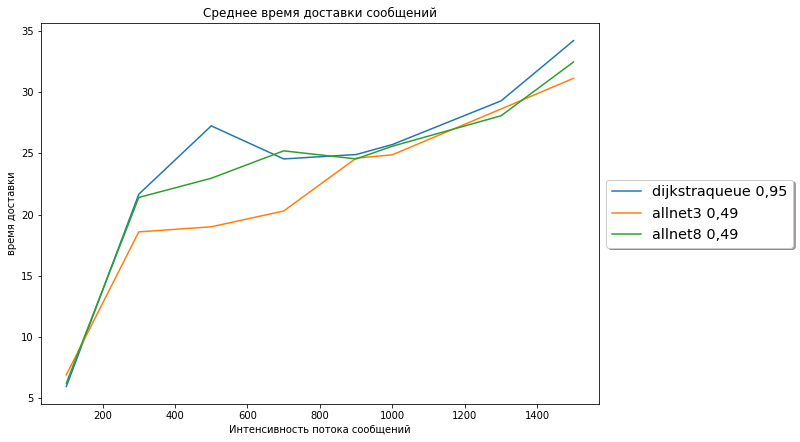

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

summInfected.sort_index(inplace=True)
axs = summInfected.plot()
axs.set_title("Средняя доля инфицированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля инфицированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()
print (MessageTimeSpent)

In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())
print("")
print(summInfected.mean().to_string())

dijkstraqueue 0,95    0.023256
allnet3 0,49          0.020512
allnet8 0,49          0.023113

dijkstraqueue 0,95    88.536680
allnet3 0,49          87.945419
allnet8 0,49          87.324973

dijkstraqueue 0,95    24.198617
allnet3 0,49          21.755428
allnet8 0,49          23.313747

dijkstraqueue 0,95    0.280688
allnet3 0,49          0.276817
allnet8 0,49          0.278144
